In [1]:
import torch
import re
import os
from typing import List, Tuple, Dict

if not os.getcwd().endswith('haawron_mmaction2'):
    os.chdir('..') 
os.getcwd()

'/data/hyogun/repos/haawron_mmaction2'

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_pyth = r'data/weights/timesformer/TimeSformer_divST_8_224_SSv2.pyth'
# w = torch.load(r'data/weights/timesformer/TimeSformer_divST_8x32_224_HowTo100M.pyth', map_location=device)
# w = torch.load(r'data/weights/timesformer/TimeSformer_divST_96x32_224_HowTo100M.pyth', map_location=device)
w = torch.load(path_pyth, map_location=device)
z = torch.load(r'data/weights/timesformer/timesformer_divST_8x32x1_15e_kinetics400_rgb-3f8e5d03.pth', map_location=device)
w.keys(), z.keys()

(dict_keys(['epoch', 'model_state', 'optimizer_state', 'cfg']),
 dict_keys(['meta', 'state_dict']))

* `'meta'`에는 mmaction 학습 정보가 들어가있음

In [7]:
TENSOR_DICT = Dict[str,torch.Tensor]
state_w:TENSOR_DICT = w.get('state_dict', w.get('model_state', w))  # state_dict -> model_state -> w itself
state_z:TENSOR_DICT = z['state_dict']
prev_layer_idx = None
RED, DEFAULT = '\x1b[31m', '\x1b[0m'
for i, ((tensor_name_w, tensor_w), (tensor_name_z, tensor_z)) in enumerate(zip(state_w.items(), state_z.items())):
    msg = f'{i:3d}  {tensor_name_z:80} {str(tuple(tensor_z.shape)):16s}\t{str(tuple(tensor_w.shape)):16s} {i:3d}  {tensor_name_w:60}'
    is_diff = tensor_z.shape != tensor_w.shape
    if is_diff:
        msg = RED + msg + DEFAULT
    layer_idx = re.findall('\.layers\.(\d+)\.', tensor_name_z)
    layer_idx = layer_idx[0] if layer_idx else None
    if layer_idx != prev_layer_idx:
        print()
    print(msg)
    prev_layer_idx = layer_idx

  0  backbone.cls_token                                                               (1, 1, 768)     	(1, 1, 768)        0  model.cls_token                                             
  1  backbone.pos_embed                                                               (1, 197, 768)   	(1, 197, 768)      1  model.pos_embed                                             
  2  backbone.time_embed                                                              (1, 8, 768)     	(1, 8, 768)        2  model.time_embed                                            
  3  backbone.patch_embed.projection.weight                                           (768, 3, 16, 16)	(768, 3, 16, 16)   3  model.patch_embed.proj.weight                               
  4  backbone.patch_embed.projection.bias                                             (768,)          	(768,)             4  model.patch_embed.proj.bias                                 
  5  backbone.norm.weight                                             

## 이상한 부분이 block 안 쪽이랑 끄트머리밖에 없음
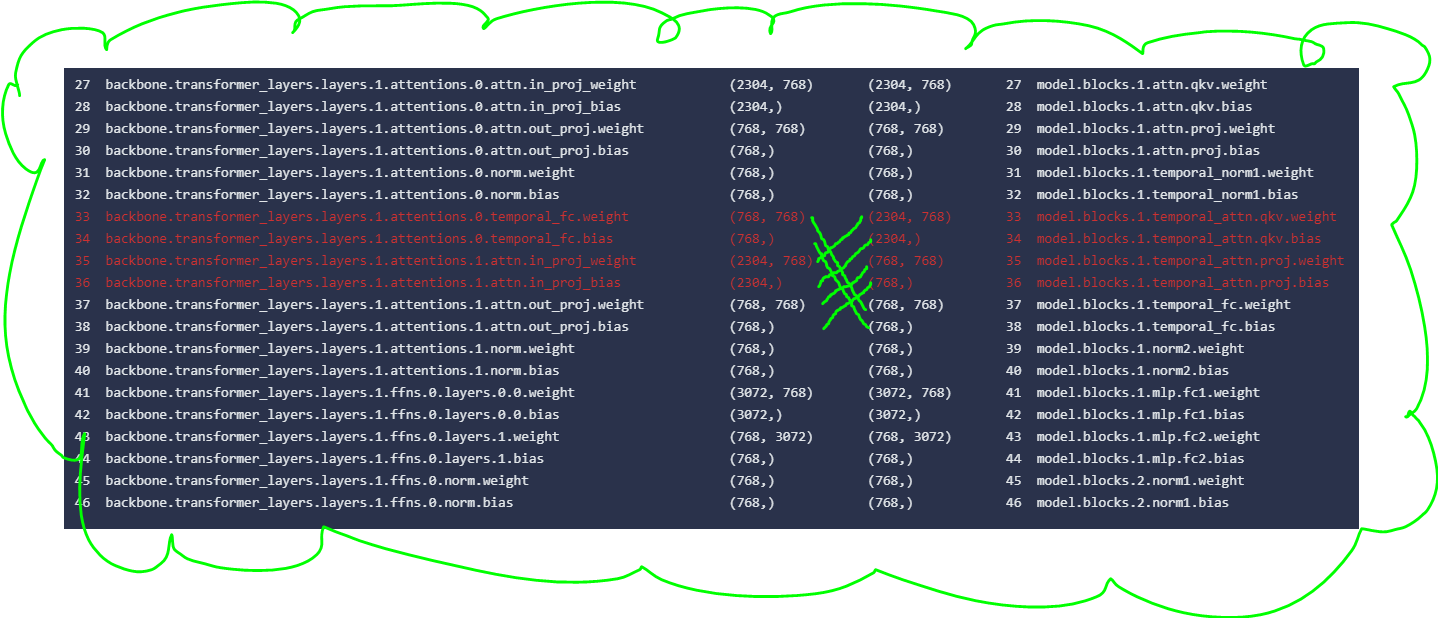
## 이렇게 이어주면 될 듯
## 끄트머리는 이름만 바꿔서 살려놓자! class 정의가 달라서 의미는 없긴 한데 호옥시 나중에 쓸 수 있음

#### TimeSFormer H100M time length 큰 모델은 time_embed가 learnable이라 안 됨
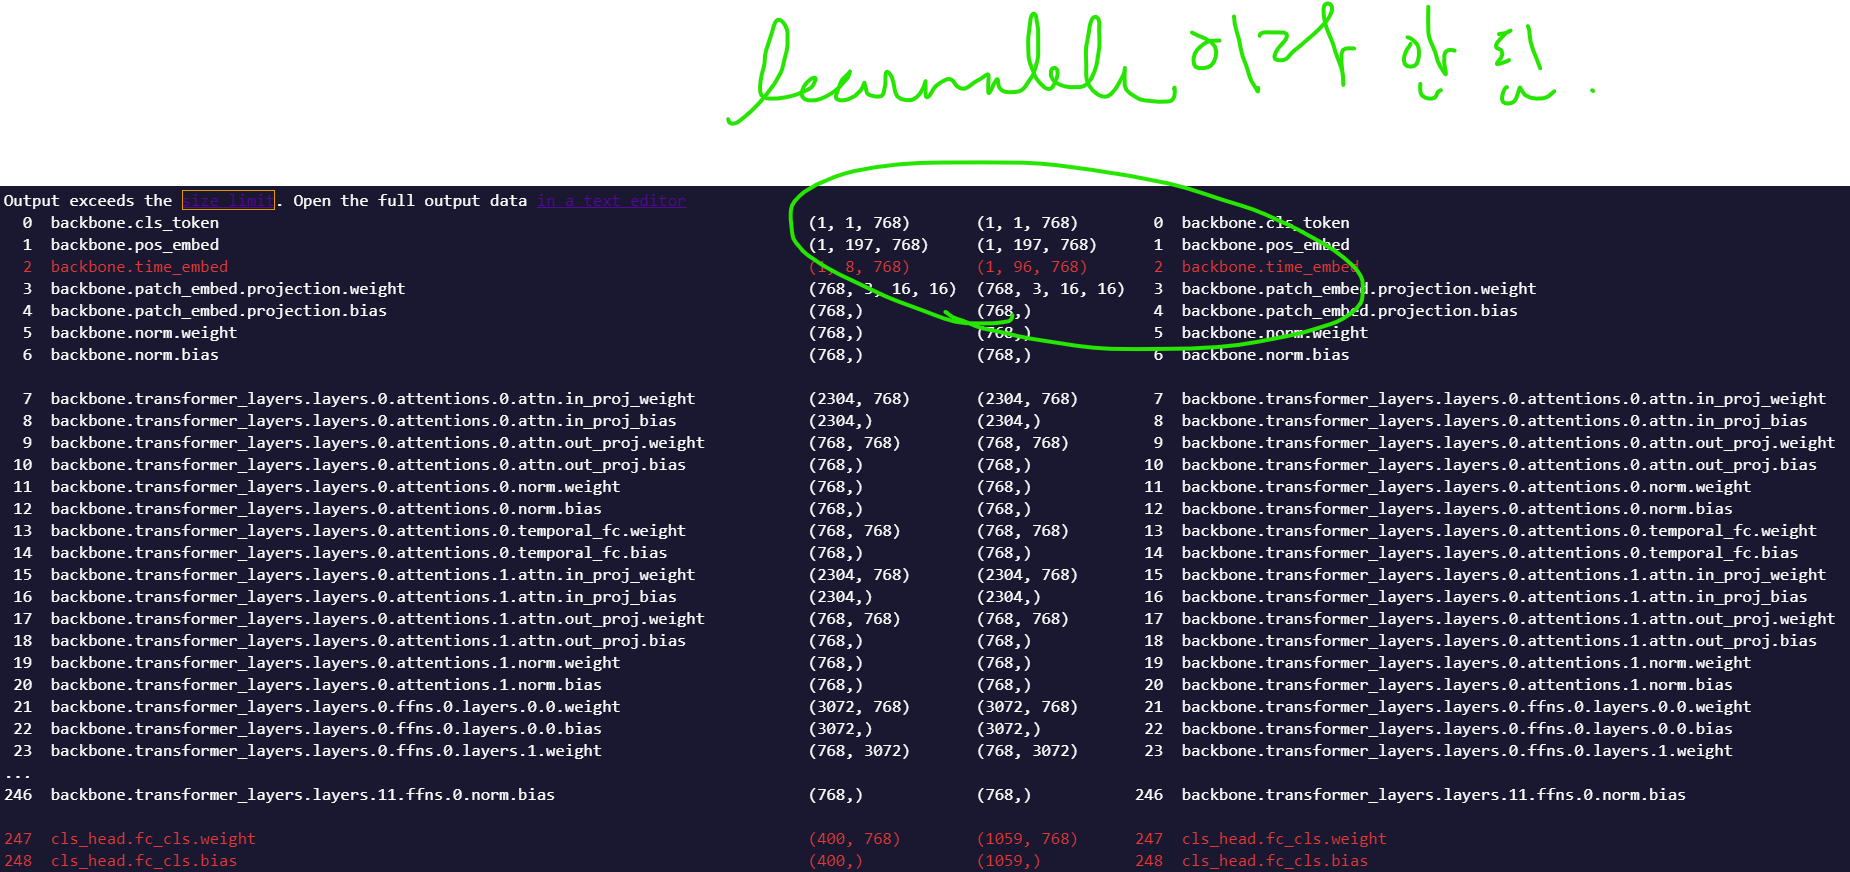

In [9]:
tensor_names_z = list(state_z.keys())
TENSOR_INFO = Tuple[str,torch.Tensor]
new_state:List[TENSOR_INFO] = []
tensors_w = list(state_w.values())
for i, tensor_name_z in enumerate(tensor_names_z):
    if 'temporal_fc' in tensor_name_z:
        new_tensor_info:TENSOR_INFO = (tensor_name_z, tensors_w[i+4])
    elif 'attentions.1.attn' in tensor_name_z:
        new_tensor_info:TENSOR_INFO = (tensor_name_z, tensors_w[i-2])
    else:
        new_tensor_info:TENSOR_INFO = (tensor_name_z, tensors_w[i])
    new_state.append(new_tensor_info)
        
# validate
for i, ((tensor_name_new, tensor_new), (tensor_name_z, tensor_z)) in enumerate(zip(new_state, state_z.items())):
    msg = f'{i:3d}  {tensor_name_z:80} {str(tuple(tensor_z.shape)):16s}\t{str(tuple(tensor_new.shape)):16s} {i:3d}  {tensor_name_new:60}'
    is_diff = tensor_z.shape != tensor_new.shape
    if is_diff:
        msg = RED + msg + DEFAULT
    layer_idx = re.findall('\.layers\.(\d+)\.', tensor_name_z)
    layer_idx = layer_idx[0] if layer_idx else None
    if layer_idx != prev_layer_idx:
        print()
    print(msg)
    prev_layer_idx = layer_idx

  0  backbone.cls_token                                                               (1, 1, 768)     	(1, 1, 768)        0  backbone.cls_token                                          
  1  backbone.pos_embed                                                               (1, 197, 768)   	(1, 197, 768)      1  backbone.pos_embed                                          
  2  backbone.time_embed                                                              (1, 8, 768)     	(1, 8, 768)        2  backbone.time_embed                                         
  3  backbone.patch_embed.projection.weight                                           (768, 3, 16, 16)	(768, 3, 16, 16)   3  backbone.patch_embed.projection.weight                      
  4  backbone.patch_embed.projection.bias                                             (768,)          	(768,)             4  backbone.patch_embed.projection.bias                        
  5  backbone.norm.weight                                             

In [24]:
from pathlib import Path
p_pyth = Path(path_pyth)
new_name = p_pyth.stem.replace('_divST', '').lower() + '_mmaction' + p_pyth.suffix
p_pyth = p_pyth.with_name(new_name)
p_pyth

PosixPath('data/weights/timesformer/timesformer_8_224_ssv2_mmaction.pyth')

In [13]:
zz = z.copy()
zz['state_dict'] = dict(new_state)
# path = 'data/weights/timesformer/timesformer_8x32_224_howto100M_mmaction.pth'
torch.save(zz, p_pyth)